In [2]:
from collections import defaultdict
from datetime import datetime
import json
import os
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))

from config import (
    RAW_DATA_PATH,
    FILTERED_DATA_PATH,
    TRAIN_DATA_PATH,
    VAL_DATA_PATH,
    TEST_DATA_PATH,
    METADATA_PATH,
    EMBEDDINGS_TITLE_PATH,
    EMBEDDINGS_DESCR_PATH,
    EPISODE_DESCRIPTION_PATH,
    RANDOM_STATE,
    N_RECOMMENDATIONS,
    N_EPOCHS,
    RECOMMENDATIONS_PATH,
    TRANSFORMED_DATA_PATH,
    SPLIT_DATE_TRAIN_VAL,
    SPLIT_DATE_VAL_TEST,
)
import utils.utils as utils

In [3]:
# importing raw data
# raw_df = pd.read_parquet("../" + RAW_DATA_PATH)

# importing training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# importing validation data
val_df = pd.read_parquet("../" + VAL_DATA_PATH)

# importing test data
test_df = pd.read_parquet("../" + TEST_DATA_PATH)

# importing metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# importing episode descriptions
descr_df = pd.read_parquet("../" + EPISODE_DESCRIPTION_PATH)

# importing the transformed data
transformed_df = pd.read_parquet("../" + TRANSFORMED_DATA_PATH)

# importing the filtered data
filtered_df = pd.read_parquet("../" + FILTERED_DATA_PATH)

# importing title embeddings
title_embeddings = pd.read_parquet("../" + EMBEDDINGS_TITLE_PATH)

# importing description embeddings
descr_embeddings = pd.read_parquet("../" + EMBEDDINGS_DESCR_PATH)

In [37]:
train_w_meta = train_df.merge(meta_df, how="left", on="prd_number")

In [22]:
descr_embeddings

,episode,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature375,feature376,feature377,feature378,feature379,feature380,feature381,feature382,feature383,feature384
0,11031452026,0.009621,0.029162,-0.002433,0.004897,-0.022147,0.010057,-0.011157,0.041700,0.061392,...,0.033174,-0.007649,-0.040873,0.152507,-0.127126,0.015639,0.045440,-0.031352,-0.012420,-0.002373
1,11031452036,-0.012926,0.081736,0.042524,0.005168,0.025241,-0.053269,0.121611,0.003747,0.052209,...,0.071749,-0.001742,-0.001790,0.037333,-0.082290,0.035079,0.113756,0.003824,-0.028524,0.028486
2,11031452096,0.099927,0.094224,-0.023470,0.010487,0.105357,-0.014408,0.015776,-0.033878,-0.009047,...,0.053778,-0.034548,-0.006880,-0.021039,0.050285,0.026841,0.009443,0.013951,0.066235,0.056208
3,11031452116,0.043847,0.156546,-0.012677,0.016094,0.014304,-0.003508,0.031349,0.058291,0.067664,...,0.020634,-0.026498,-0.033818,0.057771,-0.154213,-0.025020,0.107723,0.021609,0.019304,0.063119
4,11031452216,0.100882,0.035081,0.023911,-0.003120,-0.000766,-0.002761,0.058619,0.049042,-0.028347,...,0.049595,-0.018405,-0.051515,-0.034902,-0.099512,0.022749,0.078256,0.085385,-0.067010,0.073788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21051,19388840409,-0.062572,0.087272,-0.003678,0.018921,-0.007601,-0.065235,0.056984,0.025525,0.043710,...,-0.065877,0.048710,-0.029364,-0.022153,-0.019462,0.014372,-0.001661,0.046795,0.001768,0.085095
21052,19388840410,-0.062572,0.087272,-0.003678,0.018921,-0.007601,-0.065235,0.056984,0.025525,0.043710,...,-0.065877,0.048710,-0.029364,-0.022153,-0.019462,0.014372,-0.001661,0.046795,0.001768,0.085095
21053,19388840411,-0.062572,0.087272,-0.003678,0.018921,-0.007601,-0.065235,0.056984,0.025525,0.043710,...,-0.065877,0.048710,-0.029364,-0.022153,-0.019462,0.014372,-0.001661,0.046795,0.001768,0.085095
21054,19388840412,-0.062572,0.087272,-0.003678,0.018921,-0.007601,-0.065235,0.056984,0.025525,0.043710,...,-0.065877,0.048710,-0.029364,-0.022153,-0.019462,0.014372,-0.001661,0.046795,0.001768,0.085095


In [23]:
emb_dict = {}
_lambda = 0.5
for _, row in title_embeddings.iterrows():
    prd_number = row["episode"]
    title_embedding = row[1:].values.flatten()
    descr_embedding = descr_embeddings[descr_embeddings["episode"] == prd_number].iloc[:, 1:].values.flatten()
    embedding = _lambda * title_embedding + (1 - _lambda) * descr_embedding
    emb_dict[prd_number] = embedding

emb_dict["11031557052"]

array([-0.0029543910876071566, 0.09945431479439573, -0.05553988790203723,
       0.00014224061736453977, 0.05099459687974859, 0.0051430203037128265,
       0.012678725707111354, 0.003017969985140884, 0.07265915602070946,
       0.023836497149477665, 0.03658547576194718, 0.012275106402785604,
       0.07622178601865225, 0.004002566542118705, 0.001856771941261691,
       -0.03643992043801448, -0.025551185769257856, -0.03218763222013195,
       -0.05183181086568496, 0.03423775344665514, 0.006811557724947782,
       -0.009290023065914414, 0.0809004981343159, -0.025724173237604966,
       0.036884467311139715, -0.05943411448566453, -0.04548943417129475,
       -0.022642390883553874, -0.010568387046484705, -0.0358667081294935,
       -0.011668254287107476, -0.05529874649376184, 0.03505809093696791,
       0.032574883948651476, 0.005135742214849873, 0.03827596306282648,
       0.08443794477564441, 0.03554668307551371, -0.0069161547304121,
       0.0060402327508122765, -0.011449020307138288, 0

In [26]:
len(val_df)

581287

In [37]:
import time

for i in tqdm(range(4), desc="Outer loop", position=0):
    for j in tqdm(range(3), desc="Inner loop", leave=False, position=1):
        time.sleep(2)


Outer loop: 100%|██████████| 4/4 [00:24<00:00,  6.02s/it]


In [38]:
for i in tqdm(range(10), desc="Outer loop", position=0, dynamic_ncols=True):
    for j in tqdm(range(3), desc="Inner loop", leave=False, position=1, dynamic_ncols=True):
        time.sleep(2)

Outer loop: 100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


In [53]:
import itertools
recommendations = [1,2,3,4,5,6]
count=0
for item1, item2 in itertools.combinations(recommendations, 2):
    count += 1
count

15

In [43]:
metadata_levels = {"title": {"emb_df": 0,
                             "rec_key": 1,
                             "scores_path": 2},
                    "descr": {"emb_df": 3,
                             "rec_key": 4,
                             "scores_path": 5},
                    "combi": {"emb_df": 6,
                             "rec_key": 7,
                             "scores_path": 8}
                    }

for level in metadata_levels.values():
    emb_df = level["emb_df"]
    rec_key = level["rec_key"]
    scores_path = level["scores_path"]
    print(emb_df)

0
3
6


[0.547945205479452, 0.273972602739726, 0.0684931506849315, 0.10958904109589042]


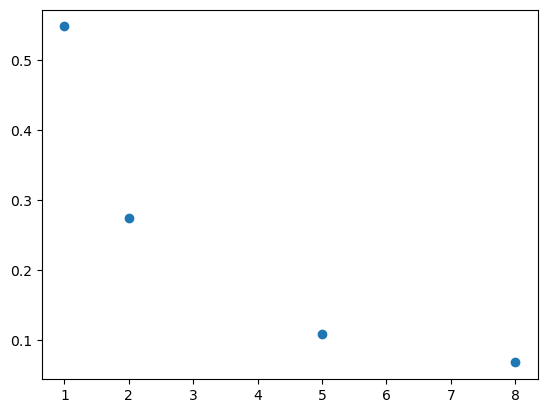

In [20]:
# inverse weights
days_list = [1,2,8,5]
weights_inv = [1 / days for days in days_list]
weights_inv_sum = sum(weights_inv)
weights = [inv_weight / weights_inv_sum for inv_weight in weights_inv]
print(weights)
import matplotlib.pyplot as plt
plt.scatter(days_list, weights)

[0.4, 0.35, 0.05, 0.2]


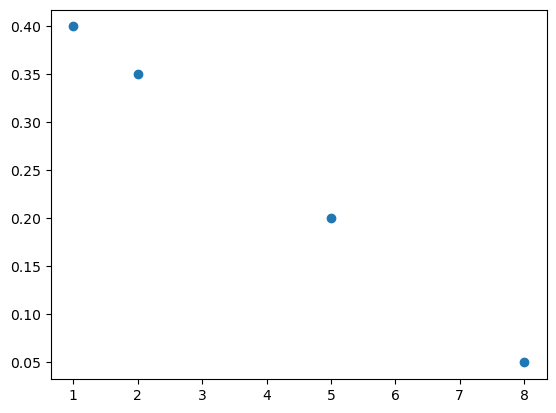

In [21]:
# linear scaling
max_days = max(days_list)
reversed = [max_days - days + 1 for days in days_list]
rev_sum = sum(reversed)
weights = [rev / rev_sum for rev in reversed]
print(weights)
plt.scatter(days_list, weights)

In [13]:
reference_date = datetime.strptime(SPLIT_DATE_TRAIN_VAL, "%Y-%m-%d")
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["days_since"] = (reference_date - train_df["date"]).dt.days
user_int = train_df[train_df["user_id"]=="00051e4d15267dd420ebac00a1382db78d74e027c55d7f5db238822e29090e87"]

# days since listened from train-val split date
# total_days = sum(user_int["days_since"])

# computing weights
days_list = user_int["days_since"].to_list()
weights_inv = [1 / days for days in days_list]
weights_inv_sum = sum(weights_inv)
weights = [inv_weight / weights_inv_sum for inv_weight in weights_inv]
print(weights)
# for i in range(len)

[0.007711128406892807, 0.00795987448453451, 0.00795987448453451, 0.061689027255142456, 0.005035838959603465, 0.005035838959603465, 0.005035838959603465, 0.0053642632395776045, 0.00587514545287071, 0.00587514545287071, 0.006018441683428532, 0.0061689027255142454, 0.006327079718476149, 0.007050174543444852, 0.00795987448453451, 0.00850883134553689, 0.01175029090574142, 0.01175029090574142, 0.012337805451028491, 0.01370867272336499, 0.014515065236504107, 0.017625436358612127, 0.01898123915542845, 0.024675610902056982, 0.041126018170094966, 0.041126018170094966, 0.041126018170094966, 0.061689027255142456, 0.005140752271261871, 0.0053642632395776045, 0.006018441683428532, 0.007050174543444852, 0.005140752271261871, 0.0053642632395776045, 0.006854336361682495, 0.08225203634018993, 0.016450407268037988, 0.061689027255142456, 0.012337805451028491, 0.012987163632661568, 0.012987163632661568, 0.01370867272336499, 0.014515065236504107, 0.006493581816330784, 0.00850883134553689, 0.0098702443608227